 All libraries imported successfully!
STEP 1: LOADING DATA

 Dataset Shape: (2102, 16)

 First few rows:
             timestamp  hour  day_of_week  month  is_weekend  is_rush_hour  \
0  2023-01-01 00:00:00     0            6      1           1             0   
1  2023-01-01 01:00:00     1            6      1           1             0   
2  2023-01-01 02:00:00     2            6      1           1             0   
3  2023-01-01 03:00:00     3            6      1           1             0   
4  2023-01-01 04:00:00     4            6      1           1             0   

   temperature   humidity  wind_speed  precipitation  atmospheric_pressure  \
0    18.349297  58.523415    6.239316       9.859608           1006.208005   
1    21.546299  53.490508    2.495386       0.027293           1003.619926   
2    21.421583  62.074480    1.496823       0.179041           1007.780986   
3    24.105350  54.901282    2.132362      12.141966           1017.390583   
4    17.249519  95.000000    7.90382

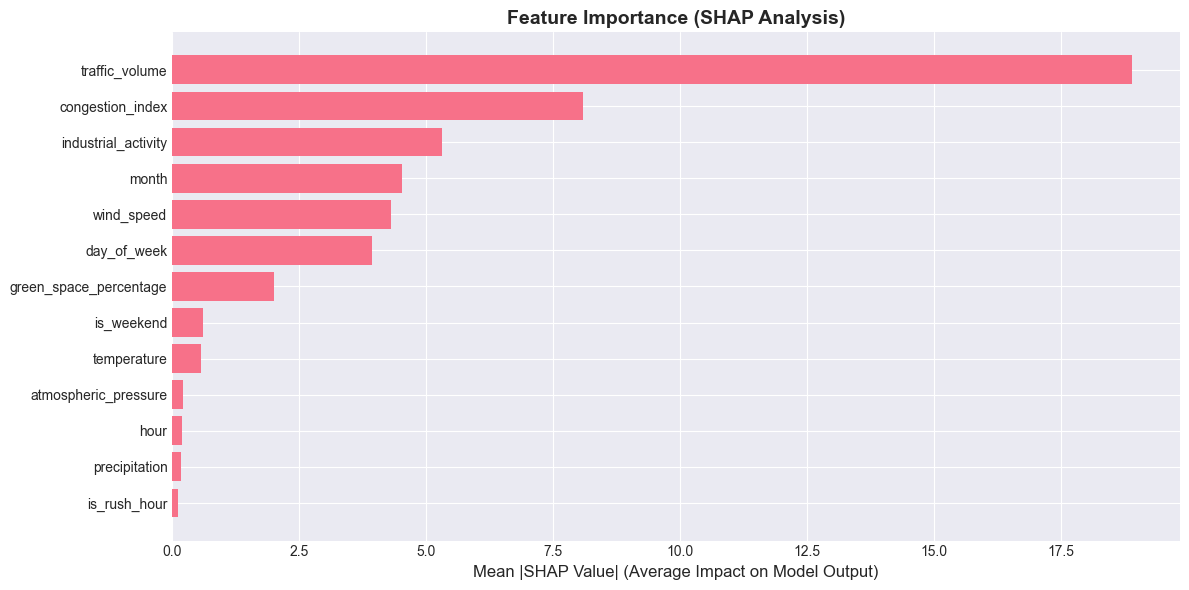

✓ Feature importance chart displayed

STEP 8: GENERATING 48-HOUR PREDICTIONS

 Generated 48-hour predictions
   Mean prediction: 60.28
   Range: 45.02 - 89.24

 AQI Category Distribution (48-hour forecast):
Moderate    36
Good        12

STEP 9: EXPORTING DATA FOR WEBAPP

 Exported: predictions_48h.csv
   Shape: (48, 7)
                   timestamp  hour       day  pollution_prediction  \
0 2026-01-01 18:24:01.484120    18  Thursday             87.441170   
1 2026-01-01 19:24:01.484120    19  Thursday             86.796341   
2 2026-01-01 20:24:01.484120    20  Thursday             56.327839   

   confidence_lower  confidence_upper aqi_category  
0         76.663276         98.219063     Moderate  
1         76.018447         97.574235     Moderate  
2         45.549945         67.105733     Moderate  

 Exported: feature_importance.csv
   Shape: (13, 3)
                feature  importance  importance_percentage
9        traffic_volume   18.902618              38.652115
10     congest

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import shap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")

print("=" * 70)
print("STEP 1: LOADING DATA")
print("=" * 70)

df = pd.read_csv('pollution_data.csv')

print(f"\n Dataset Shape: {df.shape}")
print(f"\n First few rows:")
print(df.head())
print(f"\n Data Info:")
print(df.info())
print(f"\n Statistical Summary:")
print(df.describe())
print(f"\n Missing Values:")
print(df.isnull().sum())


print("\n" + "=" * 70)
print("STEP 2: DATA PREPROCESSING")
print("=" * 70)

if df.isnull().sum().sum() > 0:
    print("\n  Handling missing values...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    print(" Missing values handled")
else:
    print("\n No missing values found")

target_col = 'pollution_level'
if target_col not in df.columns:
    possible_targets = [col for col in df.columns if 'pollution' in col.lower() or 'pm' in col.lower() or 'aqi' in col.lower()]
    if possible_targets:
        target_col = possible_targets[0]
        print(f"\n Using '{target_col}' as target variable")

exclude_cols = [target_col]
for col in df.columns:
    if df[col].dtype == 'object' or 'id' in col.lower() or 'date' in col.lower() or 'time' in col.lower():
        if col != target_col:
            exclude_cols.append(col)

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Features ({len(feature_cols)}): {feature_cols}")
print(f" Target: {target_col}")

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target shape: {y.shape}")


print("\n" + "=" * 70)
print("STEP 3: TRAIN-TEST SPLIT & FEATURE SCALING")
print("=" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("\n Features scaled using StandardScaler")


print("\n" + "=" * 70)
print("STEP 4: TRAINING MODELS")
print("=" * 70)

models = {}
predictions = {}
metrics = {}

print("\n Training Linear Regression (Baseline)...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

models['Linear Regression'] = lr_model
predictions['Linear Regression'] = lr_pred

print(" Linear Regression trained")

print("\n Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)  
rf_pred = rf_model.predict(X_test)

models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_pred

print(" Random Forest trained")

print("\n Training XGBoost (Primary Model)...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)  
xgb_pred = xgb_model.predict(X_test)

models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_pred

print(" XGBoost trained")


print("\n" + "=" * 70)
print("STEP 5: MODEL EVALUATION")
print("=" * 70)

for model_name, pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"\n {model_name}:")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAE:  {mae:.2f}")
    print(f"   R²:   {r2:.4f}")

metrics_df = pd.DataFrame(metrics).T
print("\n" + "=" * 70)
print(" MODEL COMPARISON SUMMARY")
print("=" * 70)
print(metrics_df.to_string())

best_model_name = metrics_df['R²'].idxmax()
best_model = models[best_model_name]
print(f"\n Best Model: {best_model_name} (R² = {metrics_df.loc[best_model_name, 'R²']:.4f})")


print("\n" + "=" * 70)
print("STEP 6: SHAP ANALYSIS (Feature Attribution)")
print("=" * 70)

print("\n Calculating SHAP values for XGBoost model...")

explainer = shap.TreeExplainer(xgb_model)

sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print(f" SHAP values calculated for {sample_size} samples")

shap_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(shap_importance.head(10).to_string(index=False))

print("\n" + "=" * 70)
print("STEP 7: FEATURE IMPORTANCE VISUALIZATION")
print("=" * 70)

plt.figure(figsize=(12, 6))
top_n = min(15, len(shap_importance))
plt.barh(range(top_n), shap_importance.head(top_n)['importance'].values)
plt.yticks(range(top_n), shap_importance.head(top_n)['feature'].values)
plt.xlabel('Mean |SHAP Value| (Average Impact on Model Output)', fontsize=12)
plt.title('Feature Importance (SHAP Analysis)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("✓ Feature importance chart displayed")

print("\n" + "=" * 70)
print("STEP 8: GENERATING 48-HOUR PREDICTIONS")
print("=" * 70)

current_time = datetime.now()
future_timestamps = [current_time + timedelta(hours=i) for i in range(48)]

future_data = []

for timestamp in future_timestamps:
    hour = timestamp.hour
    day_of_week = timestamp.weekday()
    is_weekend = 1 if day_of_week >= 5 else 0
    is_rush_hour = 1 if hour in [7, 8, 9, 17, 18, 19] else 0
    
    feature_dict = {}
    
    for col in feature_cols:
        if col == 'hour':
            feature_dict[col] = hour
        elif col == 'day_of_week':
            feature_dict[col] = day_of_week
        elif col == 'is_weekend':
            feature_dict[col] = is_weekend
        elif col == 'is_rush_hour':
            feature_dict[col] = is_rush_hour
        elif 'traffic' in col.lower() or 'congestion' in col.lower():
          
            base_value = X[col].mean()
            feature_dict[col] = base_value * (1.5 if is_rush_hour else 0.8)
        elif 'temperature' in col.lower():
            
            base_temp = X[col].mean()
            feature_dict[col] = base_temp + 5 * np.sin(2 * np.pi * hour / 24)
        else:
            
            feature_dict[col] = X[col].mean() + np.random.normal(0, X[col].std() * 0.1)
    
    future_data.append(feature_dict)

future_df = pd.DataFrame(future_data)


future_predictions = xgb_model.predict(future_df)

test_residuals = y_test - xgb_pred
residual_std = np.std(test_residuals)
confidence_lower = future_predictions - 1.96 * residual_std
confidence_upper = future_predictions + 1.96 * residual_std

future_predictions = np.clip(future_predictions, 0, 300)
confidence_lower = np.clip(confidence_lower, 0, 300)
confidence_upper = np.clip(confidence_upper, 0, 300)

print(f"\n Generated 48-hour predictions")
print(f"   Mean prediction: {future_predictions.mean():.2f}")
print(f"   Range: {future_predictions.min():.2f} - {future_predictions.max():.2f}")


def categorize_aqi(value):
    """Categorize pollution level into AQI categories"""
    if value <= 50:
        return 'Good'
    elif value <= 100:
        return 'Moderate'
    elif value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif value <= 200:
        return 'Unhealthy'
    elif value <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'


aqi_categories = [categorize_aqi(val) for val in future_predictions]

print("\n AQI Category Distribution (48-hour forecast):")
category_counts = pd.Series(aqi_categories).value_counts()
print(category_counts.to_string())


print("\n" + "=" * 70)
print("STEP 9: EXPORTING DATA FOR WEBAPP")
print("=" * 70)


predictions_export = pd.DataFrame({
    'timestamp': future_timestamps,
    'hour': [t.hour for t in future_timestamps],
    'day': [t.strftime('%A') for t in future_timestamps],
    'pollution_prediction': future_predictions,
    'confidence_lower': confidence_lower,
    'confidence_upper': confidence_upper,
    'aqi_category': aqi_categories
})

predictions_export.to_csv('predictions_48h.csv', index=False)
print("\n Exported: predictions_48h.csv")
print(f"   Shape: {predictions_export.shape}")
print(predictions_export.head(3))


feature_importance_export = shap_importance.copy()
feature_importance_export['importance_percentage'] = (
    feature_importance_export['importance'] / feature_importance_export['importance'].sum() * 100
)

feature_importance_export.to_csv('feature_importance.csv', index=False)
print("\n Exported: feature_importance.csv")
print(f"   Shape: {feature_importance_export.shape}")
print(feature_importance_export.head(3))


n_samples = min(15, len(X_test_sample))
sample_indices = np.linspace(0, len(X_test_sample)-1, n_samples, dtype=int)

shap_samples = []

for idx in sample_indices:
    sample_idx = X_test_sample.index[idx]
    base_value = explainer.expected_value
    prediction = xgb_model.predict(X_test_sample.iloc[[idx]])[0]
    actual = y_test.loc[sample_idx]
    
    
    sample_row = {
        'sample_id': f'sample_{idx+1}',
        'actual_pollution': actual,
        'predicted_pollution': prediction,
        'base_value': base_value,
        'error': abs(prediction - actual)
    }
    
    
    for feat_idx, feature in enumerate(feature_cols):
        shap_value = shap_values[idx, feat_idx]
        feature_value = X_test_sample.iloc[idx][feature]
        sample_row[f'{feature}_value'] = feature_value
        sample_row[f'{feature}_shap'] = shap_value
    
    shap_samples.append(sample_row)

shap_samples_df = pd.DataFrame(shap_samples)
shap_samples_df.to_csv('shap_sample_predictions.csv', index=False)

print("\n Exported: shap_sample_predictions.csv")
print(f"   Shape: {shap_samples_df.shape}")
print(f"   Columns: {len(shap_samples_df.columns)}")

print("\n" + "=" * 70)
print(" PIPELINE COMPLETE - FINAL SUMMARY")
print("=" * 70)

print("\n MODEL PERFORMANCE:")
print(f"   Best Model: {best_model_name}")
print(f"   Test R²: {metrics_df.loc[best_model_name, 'R²']:.4f}")
print(f"   Test RMSE: {metrics_df.loc[best_model_name, 'RMSE']:.2f}")
print(f"   Test MAE: {metrics_df.loc[best_model_name, 'MAE']:.2f}")

print("\n EXPORTED FILES:")
print("    predictions_48h.csv (48 rows × 7 columns)")
print("    feature_importance.csv (ranked features)")
print("    shap_sample_predictions.csv (15 detailed samples)")

print("\n TOP 5 MOST IMPORTANT FEATURES:")
for i, row in feature_importance_export.head(5).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance_percentage']:.1f}%")

print("\n PREDICTION VALIDATION:")
print(f"   48-hour average: {future_predictions.mean():.1f}")
print(f"   Prediction range: {future_predictions.min():.1f} - {future_predictions.max():.1f}")
print(f"   Most common AQI: {pd.Series(aqi_categories).mode()[0]}")

print("\n" + "=" * 70)
print(" ALL SYSTEMS READY FOR HACKATHON DEMO!")
print("=" * 70)


print("\n Quick Sanity Checks:")
check_passed = True

if predictions_export['pollution_prediction'].between(0, 300).all():
    print("    All predictions within valid range [0-300]")
else:
    print("     Some predictions outside valid range")
    check_passed = False

if len(feature_importance_export) == len(feature_cols):
    print("    All features have importance scores")
else:
    print("     Missing feature importance data")
    check_passed = False

if shap_samples_df['error'].mean() < metrics_df.loc[best_model_name, 'MAE'] * 1.5:
    print("    SHAP samples representative of model performance")
else:
    print("    SHAP samples may not be representative")
    check_passed = False

if check_passed:
    print("\n All validation checks passed!")
else:
    print("\n  Some validation checks failed - review output above")

print("\n Ready for integration with React frontend!")
print(" Use the exported CSVs to build your visualization dashboard")